# target

compare truth level info with nominal

1. event number match

2. p4 vector dR match (bbll)

In [1]:
import os,shutil
import numpy as np
import ROOT
from ROOT import TCanvas, TLegend, TFile, TPaveLabel, TPaveText, TTree, TLorentzVector, TH1D, TVectorT, gStyle, THStack, gPad, TH2D
from ROOT import gROOT
import helper

Welcome to JupyROOT 6.24/08


In [2]:
# 1. get tfile
filename = "user.cgarvey.32744802._000002.output.root"
file = TFile(filename)
# 2. get ttree
nominal = file.Get("nominal")
truth = file.Get("truth")
print(nominal.GetEntries(), truth.GetEntries())

258576 4580000


In [3]:
eventNumber = TH1D ("eventNumber ","eventNumber" ,50 ,0,50)
m_bl1D = TH1D ("m_bl ","invariant mass of bl pair by truth match" ,50 ,0 ,250)
m_bl2D = TH2D ("m_bl", "masses of two lb pairs", 50 ,0 ,300, 50 ,0 ,300)
m_bl1  = TH1D ("m_bl1 ","invariant mass of bl pair by minimax" ,50 ,0 ,250)
m_bl2  = TH1D ("m_bl2 ","invariant mass of left bl pair" , 50 ,0 ,250)
m_bl1D_minimax = TH1D ("m_bl_minimax","invariant mass of bl pair by minimax" ,50 ,0 ,250)

In [4]:
eventNumber.Reset()
# event match
nentry = 0
valid = 0
minimax_matched = 0
nominal.GetEntry(nentry)
nnumber = getattr(nominal, "eventNumber")
# for n in range(truth.GetEntries()):
for n in range(800000):
    truth.GetEntry(n)
    tnumber = getattr(truth, "eventNumber")
    if tnumber == nnumber:
        #####################################################
        ############# start analysis from here ##############
        #####################################################
        # construct p4 vector 
        ## truth level llbb
        p4s_truth_b = []
        p4s_truth_b.append(helper.p4_from_pt_eta_phi_m(truth, "MC_b_from_t"))
        p4s_truth_b.append(helper.p4_from_pt_eta_phi_m(truth, "MC_b_from_tbar"))
        # first element from t, second element from tbar

        ## lepton (el/mu/tau)
        prefixes = ['MC_Wdecay1_from_t', 'MC_Wdecay2_from_t', 'MC_Wdecay1_from_tbar','MC_Wdecay2_from_tbar']
        p4s_truth_lep = helper.get_leptons_from_truth(prefixes, truth)
            
        ## nominal level llbb (same as in minimax_lb.ipynb)
        p4s_lep = helper.GetLorenzP4List(nominal, 'lep')
        p4s_bjet = helper.GetLorenzP4List(nominal,'bjet')




        # dR match p4 vector: p4s_lep vs p4s_truth_lep; p4s_bjet vs p4s_truth_b
        ## arrange the p4s as [from_b , from_bbar]
        if len(p4s_truth_lep)*len(p4s_lep)*len(p4s_truth_b)*len(p4s_bjet) == 0:
            nentry += 1
            nominal.GetEntry(nentry)
            nnumber = getattr(nominal, "eventNumber")
            continue


        p4s_match_lep = helper.deltaR_match(p4s_truth_lep, p4s_lep, 0.4)
        p4s_match_bjet = helper.deltaR_match(p4s_truth_b, p4s_bjet, 0.4)
        
        # if one of the match failed (more or less than 2 exact match), go to the next nominal event
        # if the match is successful:
        
        if len(p4s_match_lep)*len(p4s_match_bjet) != 0 :
            m1_truth = (p4s_match_lep[0] + p4s_match_bjet[0]).M()/1000
            m2_truth = (p4s_match_lep[1] + p4s_match_bjet[1]).M()/1000
            m_bl1D.Fill(m1_truth)
            m_bl1D.Fill(m2_truth)
            valid += 1

            ## minimax
            if len(p4s_lep) ==2 and len(p4s_bjet) == 2:
                idx_l, idx_b = helper.minimax_cross(p4s_lep, p4s_bjet)
                # draw the correct combination
                # fill hist
                m_bl1D_minimax.Fill((p4s_lep[idx_l] + p4s_bjet[idx_b]).M()/1000)
                m_bl1D_minimax.Fill((p4s_lep[1 - idx_l] + p4s_bjet[1 - idx_b]).M()/1000)
                

            # check if is correct:
            for k in [0, 1]:
                dR1 = ROOT.Math.VectorUtil.DeltaR(p4s_lep[idx_l],p4s_match_lep[k])
                dR2 = ROOT.Math.VectorUtil.DeltaR(p4s_bjet[idx_b],p4s_match_bjet[k])
                if dR1 < 0.00001 and dR2 < 0.00001:
                    minimax_matched += 1
                    break
             
      
        #####################################################
        ############# end analysis from here ################
        #####################################################
        nentry += 1
        nominal.GetEntry(nentry)
        nnumber = getattr(nominal, "eventNumber")
        
print(nentry, valid, minimax_matched)


ValueError: attempt to get argmin of an empty sequence

28.792085497642393 28.848138640833096
95.79973044123257 97.2987304150947


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


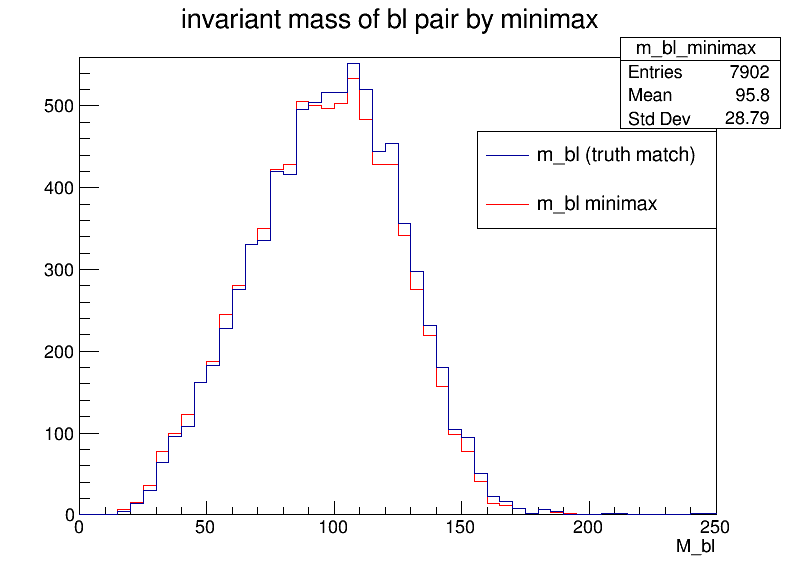

In [ ]:
c1 = TCanvas('c1', 'canvas1', 0, 0, 800, 600 )

m_bl1D_minimax.SetLineColorAlpha(2, 1)
m_bl1D_minimax.Draw()
m_bl1D_minimax.GetXaxis().SetTitle("M_bl")

m_bl1D.Draw('same')


# m_bl1.SetLineColorAlpha(2, 1)
# m_bl1.Draw("same")
# m_bl2.SetLineColorAlpha(4, 1)
# m_bl2.Draw("same")


leg = TLegend(0.6,0.6,0.9,0.77)
leg.AddEntry(m_bl1D,"m_bl (truth match)", "l")
leg.AddEntry(m_bl1D_minimax,"m_bl minimax", "l")

# leg.AddEntry(m_bl1,"m_bl1 (mini_max pair)","l")
# leg.AddEntry(m_bl2,"m_bl2 (left out pair)","l")
leg.Draw()

c1.Draw()

print(m_bl1D_minimax.GetRMS(), m_bl1D.GetRMS())
print(m_bl1D_minimax.GetMean(), m_bl1D.GetMean())

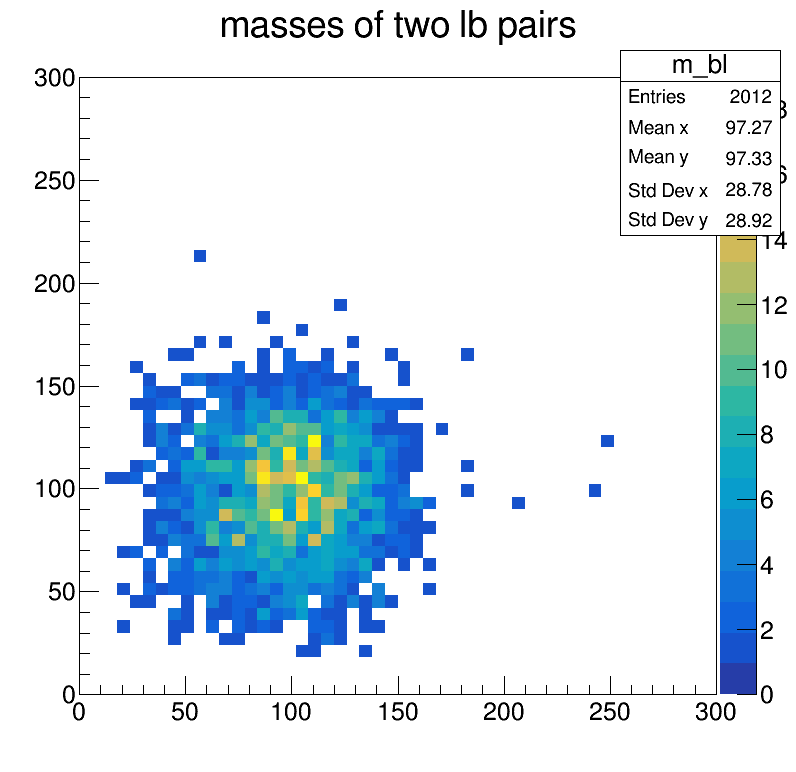

In [ ]:
c2 = TCanvas('c2', 'canvas2', 0, 0, 800, 800 )
m_bl2D.Draw("COLZ")

c2.Draw()
